# **LONG STEPS in GRADIENT DESCENT METHODS**

## **Install**

### Firedrake

In [ ]:
try:
    import google.colab  # noqa: F401
except ImportError:
    from firedrake import *
else:
    try:
        from firedrake import *
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh"
        !bash "/tmp/firedrake-install.sh"
        from firedrake import *

### Other

In [194]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

## **General functions**

### Constrained optimisation Firedrake code

In [195]:
def constrained_optimisation(nx=2**7, degree=1, gamma=2**32, max_iters=2**6, energy_exact=None, method="Newton", h=None):
    # UFL-ify constants
    gamma = Constant(gamma)
    if h:
      h = Constant(h)

    # Mesh
    mesh = UnitSquareMesh(nx, nx, quadrilateral=True)
    V = FunctionSpace(mesh, "Q", degree)

    # Constraint function f(x, y): circular bump
    x, y = SpatialCoordinate(mesh)
    cylinders = (
        ((0.4, 0.6), 0.3, 1.0),
        ((0.6, 0.4), 0.2, 0.8),
    )
    f = conditional((x - cylinders[0][0][0])**2 + (y - cylinders[0][0][1])**2 <= cylinders[0][1]**2, cylinders[0][2],
        conditional((x - cylinders[1][0][0])**2 + (y - cylinders[1][0][1])**2 <= cylinders[1][1]**2, cylinders[1][2],
        0.0
    ))

    # Functions
    u = Function(V)
    u_ = Function(V)
    v = TestFunction(V)

    # BCs
    bcs = DirichletBC(V, 0.0, "on_boundary")

    # Energy
    h1_seminorm = 0.5 * inner(grad(u_), grad(u_)) * dx
    constraint_viol = 0.5 * conditional(lt(u_, f), (u_ - f)**2, 0) * dx
    E = h1_seminorm + gamma * constraint_viol

    # Residual
    if method == "Newton":
        F = (
            inner(grad(u), grad(v))
          + gamma * conditional(lt(u_, f), (u - f) * v, 0)
        ) * dx
    elif method == "GD":
        if h:
            h1_norm = (
                inner(grad(u - u_), grad(v))
              + gamma * inner(u - u_, v)
            ) * dx
            E_prime = (
                inner(grad(u_), grad(v))
              + gamma * conditional(lt(u_, f), (u_ - f) * v, 0)
            ) * dx
            F = h1_norm + E_prime
        else:
            raise ValueError("If GD is chosen for the method, h must be specified")
    else:
        raise ValueError("method must be either Newton or GD")

    # Newton's method
    energy = assemble(E)
    energies = [energy]
    print(GREEN % f"Energy: {energy}")
    for k in range(max_iters):
        # print(BLUE % f"Newton iterate {k+1}...")
        solve(F == 0, u, bcs)
        u_.assign(u)
        energy = assemble(E)
        energies += [energy]
        print(GREEN % f"Energy: {energy}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

    # Left: log energy error convergence
    energy_errors = [abs(energy - energy_exact) for energy in energies]

    if method == "Newton":
        ax1.semilogy(range(len(energy_errors)), energy_errors, marker='o')
    else:
        ax1.loglog(range(len(energy_errors)), energy_errors, marker='o')
    ax1.set_xlabel("Newton iterate")
    ax1.set_title("Energy errors")
    ax1.grid(True, which="both", ls="--", alpha=0.6)

    # Right: contour plot
    tpc = tripcolor(u, axes=ax2)
    # Create contour lines
    cntr = tricontour(u, levels=10, colors='w', linewidths=1.0, axes=ax2)
    ax2.set_aspect('equal')
    ax2.set_title("Contour plot")
    fig.colorbar(tpc, ax=ax2, orientation='vertical')
    for (center, width, height) in cylinders:
        circ = Circle(center, width, fill=False, color='k', linestyle='-', linewidth=2.0)
        ax2.add_patch(circ)

    plt.tight_layout()
    plt.show()

## **Motivation:** When Newton fails

We're all used to using Newton, and who can blame us?

When it works, the convergence is superb ($\mathcal{O}(C^{- n^2})$*).
However, it's not always the best tool for the job:

1. Newton–Kantorovich (i.e. the convergence result for Newton in the continuous setting) requires **local Lipschitz differentiability** of the residual. It's relatively easy to cook up situations where this is violated, e.g. say we want to minimise this funky functional:
$$
E(u) := \frac{1}{2}\int\|\nabla u\|^2 + \frac{\lambda}{2}\int_{u \le f}(u-f)^2.
$$
This kind of functional** is pretty much the simplest way to approach constrained optimisation, i.e. as $\lambda \to \infty$, we expect the minimiser of $E$ to be the $u$ that minimises $\int \|\nabla u\|^2$ subject to $u \ge f$.

    However, the (Fréchet) derivative of $E$,
    $$
    E'(u; v) = \int \nabla u \cdot \nabla v + \lambda\int_{u \le f}(u - f)v,
    $$
    is **not Lipschitz differentiable** in $H^1$.
    No surprise then, we see Newton really struggles to minimise $E$.

> **It's a bit technical about whether this result holds in the continuous setting, but let's just assume it does.*

> ***C.F. Nemystkii operators.*

Energy: 696906895.1071609
Energy: 12890.710975199065
Energy: 1279.341866305218
Energy: 149502.48704439096
Energy: 524217.3057128633
Energy: 15749.330759318875
Energy: 1095.9473851632272
Energy: 163.70296743472477
Energy: 33216.78610500322
Energy: 3842.005751835477
Energy: 120.10424475643951
Energy: 23.968466296730472
Energy: 34.30857582576243
Energy: 60.667092835121714
Energy: 23.919873323398175
Energy: 18.493354537856973
Energy: 90.82133566828763
Energy: 12.906727919686881
Energy: 9.27879468119835
Energy: 7.662638974231563
Energy: 10.109659367983282
Energy: 15.211361311280195
Energy: 7.844502118446891
Energy: 7.491459791298945
Energy: 11.126255551684306
Energy: 21.83449856522667
Energy: 12.321111298231267
Energy: 19.695659871548127
Energy: 8.68802838554225
Energy: 7.43553473373014
Energy: 7.942581588441606
Energy: 7.84951655979983
Energy: 7.872852258070288
Energy: 8.127119161996406
Energy: 8.456630550258236
Energy: 9.785753040656203
Energy: 7.035161159955918
Energy: 9.827533886936655


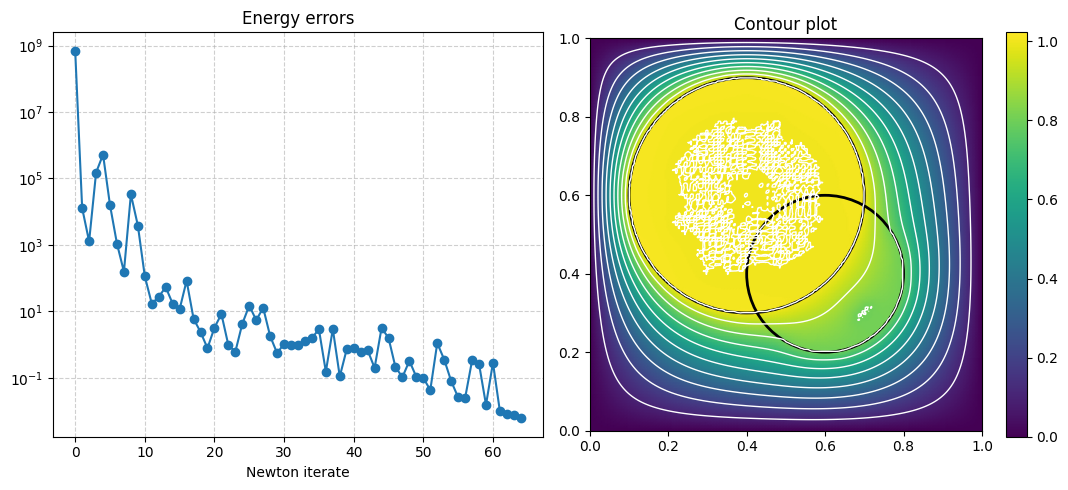

In [ ]:
constrained_optimisation(nx=2**7, degree=1, gamma=2**32, max_iters=2**6, energy_exact=6.881792651781006)

2. Something we've all encountered:
Your initial guess might just lie **outside an attractive basin**.
This is especially common when you're looking at **highly nonlinear** problems with **multiple solutions**.

3. In Newton's method, the Jacobian, i.e. the linear operator we have to invert, changes at every iteration.
For instance, when minimising an energy functional, the Newton iterates are given by
$$
0 = E'(u_n; v) + E''(u_n; u_{n+1} - u_n, v).
$$
The Jacobian here is then $E''(u_n; \cdot, \cdot)$.

    The **assembly of this Jacobian** can massively **dominate the computation time**.
    This is especially true when you're at a high order, and you don't have so many tricks at your disposal to ensure this linear operator remains sparse.

Energy: 696964017.4677631
Energy: 589023.0282176352
Energy: 43522.487828276564
Energy: 2260.1594453840817
Energy: 287.18959588464395
Energy: 104.65795805537135
Energy: 89.95633282180269
Energy: 45.91706333351465
Energy: 28.411412361757133
Energy: 20.171480599525005
Energy: 12.298812235182986
Energy: 11.411671730111346
Energy: 17.32805570234971
Energy: 12.481823848931107
Energy: 9.991273860598277
Energy: 16.69282248714758
Energy: 15.27194618591934
Energy: 13.781616430088029
Energy: 15.13871495111502
Energy: 12.186430152713935
Energy: 15.455472617328681
Energy: 11.288588056841565
Energy: 12.41395100742873
Energy: 10.48201209258988
Energy: 7.973753547066146
Energy: 6.754033901220534
Energy: 6.7513671073893855
Energy: 6.752289676997837
Energy: 6.750250981814733
Energy: 6.750486784548314
Energy: 6.751023402685967
Energy: 6.749275019815887
Energy: 6.752409673329735


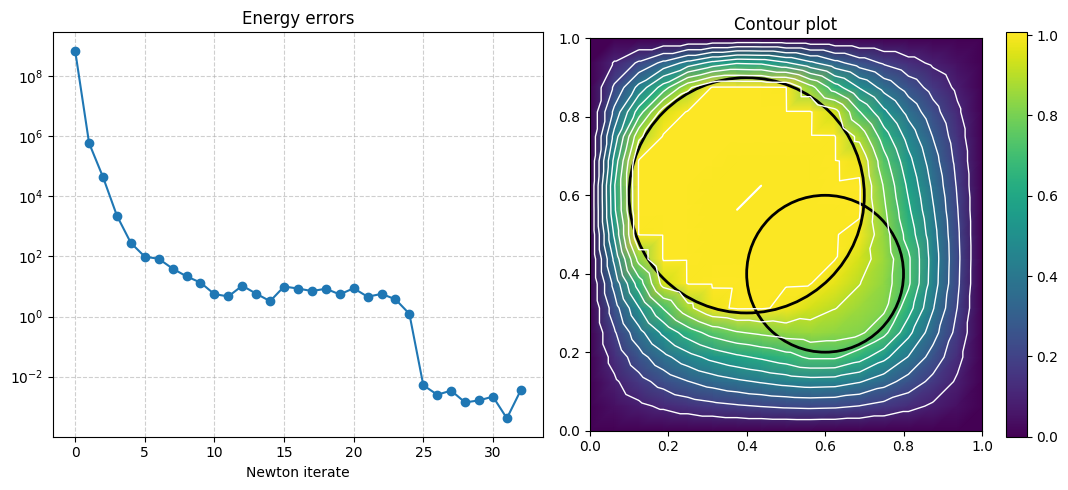

In [197]:
constrained_optimisation(nx=2**3, degree=14, gamma=2**32, max_iters=2**5, energy_exact=6.748865800378693)

Let's discuss a pretty robust alternative then...

## **Back to basics:** Gradient descent (GD)

Let's restrict our attention to energy minimisation problems.
You might never have seen GD in the function space setting before, but the idea's identical.
Instead of the update
$$
\mathbf{x}_{n+1} = \mathbf{x}_n - h\nabla E(\mathbf{x}_n),
$$
we have
$$
(u_{n+1}, v) = (u_n, v) - hE'(\mathbf{x}_n; v).
$$

So how does it square up against Newton?
Well, the convergence rates are **bad** (more on this later) but there are a lot of pros:

1. You get convergence for $h \in (0, 2/L)$, where $L$ is the Lipschitz constant of $E'$, i.e. such that.
The immediate consequence of this is that we need **one lower level of regularity**, i.e. we need only assert that $E$ is Lipschitz differentiable, not *twice* Lipschitz differentiable as in Newton.

2. This **convergence is guaranteed**, no matter where you start.
No need to stress about multiple solutions and attractive basins, no matter how nonlinear your problem.

3. The inner product we need to invert is always the **canonical inner product on our function space**.
Much less to re-assemble every iteration, and much, much easier to invert efficiently at high order.

I'll repeat though: The convergence rates are **so, so bad**.

Energy: 696964017.4677631
Energy: 592604.3608147559
Energy: 160622.573132253
Energy: 48548.87642715127
Energy: 17212.874626350378
Energy: 7383.536549081677
Energy: 3730.5894296669903
Energy: 2107.567911035759
Energy: 1295.735877297495
Energy: 862.4566019502663
Energy: 620.9327876559162
Energy: 481.78273486037756
Energy: 399.2417829552551
Energy: 348.939624489523
Energy: 317.47062482
Energy: 297.2744304920152
Energy: 283.94429481186023
Energy: 274.8744939144849
Energy: 268.52298610105316
Energy: 263.94123940720914
Energy: 260.5800119542689
Energy: 258.08266628354795
Energy: 256.20575418586054
Energy: 254.78325946100048
Energy: 253.6982909432555
Energy: 252.8658784194648
Energy: 252.22349622082737
Energy: 251.72469808473457
Energy: 251.3347388262831
Energy: 251.02746294946945
Energy: 250.78309856363248
Energy: 250.586664367806
Energy: 250.42680279212914


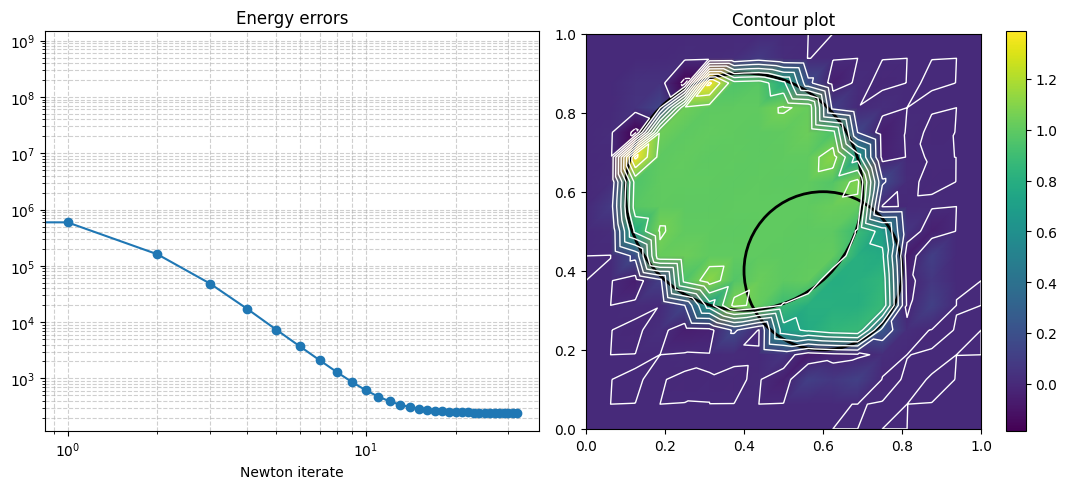

In [204]:
constrained_optimisation(nx=2**3, degree=14, gamma=2**32, max_iters=2**5, method="GD", h=1.9, energy_exact=6.748865800378693)

We can see it's effectively stalled, with the solution looking like a shrinkwrap.
Not to mention that's a log plot on the x axis now too.

Let's investigate that...

## **2D demo**

In [49]:
# Shared utility functions for lightweight GD demos
import numpy as np
import matplotlib.pyplot as plt

def quad(x, A):
    return 1/2 * np.dot(x, A @ x)

def grad_quad(x, A):
    return A @ x

def gd_quad(x0=None, A=np.diag([1.0, 5.0]), h="Linesearch", n_steps=20):
    """
    Gradient descent on quadratic 1/2 x^T A x.
    Args:
      x0: initial point (shape (2,) for 2D)
      A: SPD matrix
      h:
        - "Linesearch": exact line search step each iteration
        - scalar: fixed step size normalized by 1/L
        - list/tuple/np.ndarray: periodic sequence of normalized step sizes
      n_steps: number of iterations
    Returns:
      path: (N+1, d) array of iterates
      errors: (N+1,) array of energies 1/2 x^T A x
    """
    path = [x0]
    errors = [quad(x0, A)]
    x = x0
    # Detect linesearch vs periodic/constant step
    use_linesearch = isinstance(h, str) and h.lower() == "linesearch"
    if not use_linesearch:
        # Normalize h into a list of floats (periodic sequence)
        if np.isscalar(h):
            h = [float(h)]
        elif isinstance(h, (list, tuple, np.ndarray)):
            h = list(np.array(h, dtype=float).ravel())
        else:
            raise ValueError("h must be 'Linesearch', a scalar, or an array-like of step sizes")
        h_len = len(h)
        if h_len == 0:
            raise ValueError("Step sequence h must be non-empty")
        lip = np.linalg.norm(A, ord=2)
        i = 0
    for _ in range(n_steps):
        g = grad_quad(x, A)
        if use_linesearch:
            gTAg = np.dot(g, A @ g)
            if gTAg == 0.0:
                gTAg = 1e-12  # avoid division by zero
            x = x - (np.dot(g, g) / gTAg) * g
        else:
            x = x - (h[i % h_len] / lip) * g
            i += 1
        path.append(x)
        errors.append(quad(x, A))
    path = np.array(path)
    errors = np.array(errors)
    return path, errors

def gd_quad_plot2D(x0=None, A=np.diag([1.0, 5.0]), h="Linesearch", n_steps=20, title=None):
    """
    Gradient descent with plotting if test is 2D
    """
    # Run gradient descent
    path, errors = gd_quad(x0=x0, A=A, h=h, n_steps=n_steps)

    # Plot
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
    # Contours
    x = np.linspace(-3, 3, 100); y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    # Vectorized evaluation of quadratic form over grid
    XY = np.stack([X.ravel(), Y.ravel()], axis=1)  # shape (N*N, 2)
    Z = (0.5 * np.einsum('ij,ij->i', XY, (XY @ A))).reshape(X.shape)
    ax1.contour(X, Y, Z, levels=20)
    ax1.plot(path[:,0], path[:,1], 'r--', label='GD path')
    ax1.plot(x0[0], x0[1], 'ro', label='initial', markersize=8)
    ax1.set_aspect('equal')
    ax1.set_title("Path of x" if title is None else title)
    ax1.legend()

    # Convergence
    ax2.plot(range(len(errors)), np.log(errors + 1e-15), 'b.-')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Energy')
    ax2.set_title('Convergence rate')
    plt.tight_layout()

    plt.show()

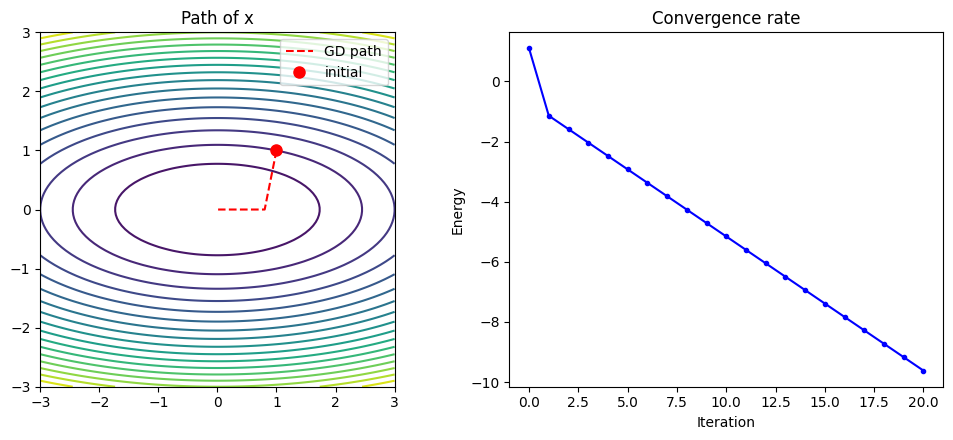

In [53]:
# Parameters
a = 5.0

# Gradient descent
gd_quad_plot2D(x0=np.array([1.0, 1.0]), A=np.diag([1.0, a]), h=1.0)

In [ ]:
# Lightweight demo: gradient descent with exact line search (with draggable initial guess)
a = 5.0
x0, y0 = 2.0, 2.0
n_steps = 20

# Initial run
path, errors, norm_steps = run_gd_linesearch(x0, y0, a, n_steps=n_steps)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
# Contours
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f_xy(X, Y, a)
ax1.contour(X, Y, Z, levels=20)
line, = ax1.plot(path[:,0], path[:,1], 'r--', label='Line search path')
point, = ax1.plot([x0], [y0], 'ro', label='initial', markersize=8)
ax1.set_aspect('equal')
ax1.set_title(f'GD + exact line search on f(x,y)=x^2+{a}y^2')
ax1.legend()

# Convergence
conv_line, = ax2.plot(range(len(errors)), np.log(errors + 1e-15), 'b.-', label='Error')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('log(||x||)')
ax2.set_title('Convergence rate')
ax2.legend()
plt.tight_layout()

# Initial normalized step sizes printout
print('Step | Normalized step size (alpha * 2a)')
for i, s in enumerate(norm_steps, 1):
    print(f'{i:4d} | {s:.3f}')

# Dragging handlers (recompute path and table)
_drag = {'active': False}

# Keep a reference to latest step sizes
_last_norm_steps = norm_steps[:]

from math import isfinite

def _update_text():
    # For simplicity in the notebook, just reprint the table
    print('\nUpdated step sizes:')
    print('Step | Normalized step size (alpha * 2a)')
    for i, s in enumerate(_last_norm_steps, 1):
        print(f'{i:4d} | {s:.3f}')


def _on_press(event):
    if event.inaxes != ax1:
        return
    contains, _ = point.contains(event)
    if contains:
        _drag['active'] = True

def _on_motion(event):
    if not _drag['active']:
        return
    if event.inaxes != ax1:
        return
    x_curr, y_curr = event.xdata, event.ydata
    if x_curr is None or y_curr is None:
        return
    point.set_data([x_curr], [y_curr])
    new_path, new_errors, new_norm_steps = run_gd_linesearch(x_curr, y_curr, a, n_steps=n_steps)
    _last_norm_steps = new_norm_steps
    line.set_data(new_path[:,0], new_path[:,1])
    conv_line.set_data(range(len(new_errors)), np.log(new_errors + 1e-15))
    ax2.relim(); ax2.autoscale_view()
    fig.canvas.draw_idle()


def _on_release(event):
    if _drag['active']:
        _update_text()
    _drag['active'] = False

cid1 = fig.canvas.mpl_connect('button_press_event', _on_press)
cid2 = fig.canvas.mpl_connect('motion_notify_event', _on_motion)
cid3 = fig.canvas.mpl_connect('button_release_event', _on_release)

plt.show()

In [ ]:
# Lightweight demo: gradient descent with periodic step sequence
a = 5.0
x0, y0 = 2.0, 2.0
n_steps = 20
seq_str = "0.95, 4.95, 0.95"
step_seq = parse_step_sequence(seq_str)

path, errors = run_gd_periodic(x0, y0, a, step_seq=step_seq, n_steps=n_steps)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
# Contours
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f_xy(X, Y, a)
ax1.contour(X, Y, Z, levels=20)
ax1.plot(path[:,0], path[:,1], 'r--', label='Periodic steps path')
ax1.plot([x0], [y0], 'ro', label='initial')
ax1.set_aspect('equal')
ax1.set_title(f'GD + periodic steps on f(x,y)=x^2+{a}y^2')
ax1.legend()

# Convergence
ax2.plot(range(len(errors)), np.log(errors + 1e-15), 'b.-')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('log(||x||)')
ax2.set_title('Convergence rate')

print('Using step sequence:', step_seq)
plt.tight_layout()
plt.show()